[nltk_data] Downloading package stopwords to C:\Users\DEVANSHI
[nltk_data]     BAVARIA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Enter Keyword/Tag to search about: bad
Enter how many tweets to search: 100
How do you want to see pie or bar chart 
1. Pie
2. Bar
2


<Figure size 1152x1152 with 0 Axes>

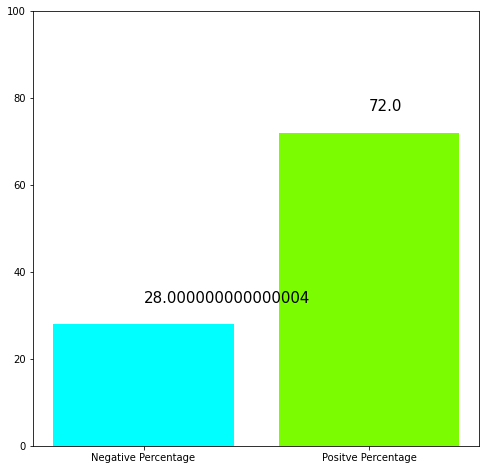

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
import tweepy
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop = stopwords.words('english')
# ------------------------------------- Inserting Data ------------------------------------
read = pd.read_csv("training.csv",names = ["target", "ids", "date", "flag", "user", "text"])
# ------------------------------------- Twitter tweets ------------------------------------
accessToken = "1433414148939935748-w68Aa1T2JlQZ8uPvorMf7AHshjtkuu"
accessTokenSecret = "ytVRmVh7ckJppLvoU9ANopqCHV3faUJZScHjm1UWT6fHQ"
consumerKey = "aWKl1hXhiH8Zqr1kwjkD6LlaN"
consumerSecret = "qdonHBnMAJkmnuYrOUmJBQhPdOQ0zshiJ58JhecIhW3qsyuEwE"
# ------------------------------------- Authentication Done -------------------------------
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)
# ------------------------------------- Appending to Dataframe -------------------------------
new_df = list(read['text'])
# ------------------------------------ input for term to be searched and how many tweets to search --------------------
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))
# ------------------------------------ Keyword will be searched on twitter --------------------
tweets = tweepy.Cursor(api.search_tweets,q=searchTerm,lang="en",).items(NoOfTerms)
# ----------------------------------- Storing into a list -----------------------------------
unfiltered = []
for x,i in enumerate(tweets):
    unfiltered.append(i.text)
    new_df.append(i.text)
unfiltered = pd.DataFrame(unfiltered)
unfiltered.to_csv('unfiltered.csv',header=False,mode='w',index=False)
# ----------------------------------- Filtering Data --------------------------------------------
new_df = pd.DataFrame(new_df,columns=['text'])
new_df['text'] = new_df['text'].replace(to_replace ='(@[\w]+)', value ='', regex = True)          
# new_df['text'] = new_df['text'].replace(to_replace =('RT'), value ='',regex = True)               
new_df['text'] = new_df['text'].str.replace('((www\.[\s]+)|(https?://[^\s]+))','\0',regex=True)   
new_df['text'] = new_df['text'].str.replace("[^a-zA-Z]+", " ")                                   
new_df["text"] = new_df["text"].str.lower()                                                       
new_df["text"] = new_df["text"].str.split()                                                       
new_df['text'] = new_df['text'].apply(lambda x: [item for item in x if item not in stop])         
tweeeeets = new_df[-NoOfTerms:]
# ------------------------------------ Selecting last tweets as user wished ---------------------
def rejoin_words(row):
    my_list = row['text']
    joined_words = ( " ".join(my_list))
    return joined_words
new_df['text'] = new_df.apply(rejoin_words, axis=1)
vectorizer=CountVectorizer(max_df=0.95,min_df=2,max_features=10000,ngram_range=(1,3),stop_words='english')
x=vectorizer.fit_transform(new_df['text'])
new_df_vectorized = vectorizer.fit_transform(new_df['text'])
# ----------------------------------- spiliting Data ------------------------
xtrain = new_df_vectorized[:-NoOfTerms]
xtest = new_df_vectorized[-NoOfTerms:]
ytrain = read['target']
bern = BernoulliNB()
# --------------------------------- Applying Algorithm -----------------------
bern.fit(xtrain,ytrain)
ypredict = bern.predict(xtest)
count_negative,count_positive = 0,0
for i in range(len(ypredict)):
    if ypredict[i] == 0:
        count_negative+=1
    else:
        count_positive+=1
neg_per = count_positive/len(ypredict)*100
pos_per = count_negative/len(ypredict)*100
tweeeeets.to_csv('Tweets.csv',header=False,index=False,mode='w')
plt.figure(figsize=(16,16))
user_input = int(input("How do you want to see pie or bar chart \n1. Pie\n2. Bar\n"))
plt.figure(figsize=(8,8),)
plt.ylim((0,100))
if user_input == 1:
    if neg_per == 0:
        plt.pie([pos_per],data =[pos_per],labels=['Postive tweets'],colors = ['lawngreen'],autopct='%1.1f%%')
    elif pos_per == 0:
        plt.pie([neg_per,],data =[neg_per,],labels=['Negative Tweets',],colors = ['cyan',],autopct='%.1f%%')
    else:
        plt.pie([neg_per,pos_per],data = [neg_per,pos_per],labels=['Negative Tweets','Postive tweets'],colors = ['cyan','lawngreen'],autopct='%1.1f%%')
elif user_input == 2:
    plt.bar(['Negative Percentage','Positve Percentage'],[neg_per,pos_per],color = ['cyan','lawngreen'])
    for i,x in zip(['Negative Percentage','Positve Percentage'],[neg_per,pos_per]):
        plt.text(i,x+5,x,size=15)
plt.savefig('Answer.jpg')
plt.show()
